**Name**: Sujan Dumaru  
**Course**: MSCS 634-B01: Advanced Big Data and Data Mining  
**Lab 2 Assignment**: Performance Comparison of KNN and RNN on the Wine Dataset

# Step 1: Load and Prepare the Dataset 

In [10]:
# import wine dataset from sklearn
from sklearn.datasets import load_wine

# load wine dataset
wine_dataset = load_wine(as_frame=True)
x = wine_dataset.data
y = wine_dataset.target

In [2]:
# print dataset description and feature names
print(wine_dataset.DESCR)
print('Features:', wine_dataset.feature_names)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [3]:
# show class distribution
counts = y.value_counts()
print('Class distribution:')
print(counts)


# Missing‐value check
print("Missing values per column:")
print(x.isnull().sum())  # Expect all zeros

Class distribution:
target
1    71
0    59
2    48
Name: count, dtype: int64
Missing values per column:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Data splitting into 80 percent train and 20 percent test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Display shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (142, 13)
x_test shape: (36, 13)
y_train shape: (142,)
y_test shape: (36,)


# Step 2: Implement K-Nearest Neighbors (KNN) 

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# evaluate KNN for various k values
k_values = [1, 5, 11, 15, 21]
knn_results = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    acc = accuracy_score(y_test, preds)
    knn_results.append((k, acc))

knn_df = pd.DataFrame(knn_results, columns=['k', 'accuracy'])
print(knn_df)

    k  accuracy
0   1  0.777778
1   5  0.722222
2  11  0.750000
3  15  0.750000
4  21  0.777778


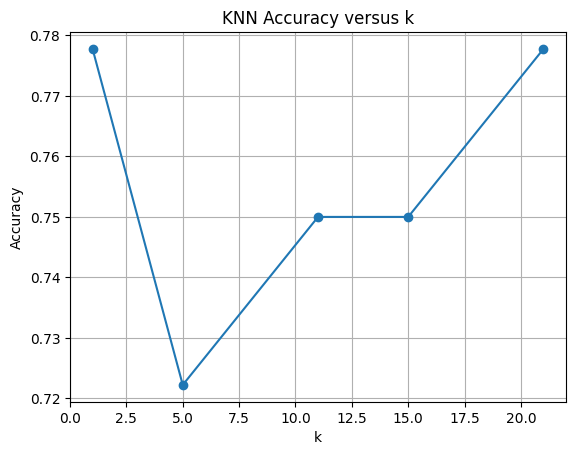

In [6]:
import matplotlib.pyplot as plt

# plot accuracy versus k
plt.plot(knn_df['k'], knn_df['accuracy'], marker='o')
plt.title('KNN Accuracy versus k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

**Observations on KNN performance**

1. Best accuracy occurs at k = 1 and k = 21, both around 0.778.
2. Lowest accuracy at k = 5 (~0.722), suggesting too much local noise.
3. Mid-range k (11 and 15) stabilize at ~0.750—trade-off between variance (low k) and bias (high k).
4. When to prefer KNN
    - Low-k when decision boundaries are complex and you have ample training data.
    - High-k when you need smoother boundaries and want to reduce sensitivity to noise.


# Step 3: Implement Radius Neighbors (RNN) 

In [7]:
from sklearn.neighbors import RadiusNeighborsClassifier

# convert DataFrames to NumPy arrays
x_train_np = x_train.values
x_test_np  = x_test.values

# evaluate Radius Neighbors for various radii
radius_values = [350, 400, 450, 500, 550, 600]
rnn_results = []

for r in radius_values:
    model = RadiusNeighborsClassifier(radius=r, outlier_label=None)
    model.fit(x_train_np, y_train)      # fit on NumPy array
    preds = []
    for sample in x_test_np:            # iterate over NumPy rows
        neigh = model.radius_neighbors([sample], return_distance=False)[0]
        if len(neigh) == 0:
            # fallback to 1-NN if no neighbors in radius
            fb = KNeighborsClassifier(n_neighbors=1).fit(x_train_np, y_train)
            preds.append(fb.predict([sample])[0])
        else:
            preds.append(y_train.iloc[neigh[0]])
    acc = accuracy_score(y_test, preds)
    rnn_results.append((r, acc))

rnn_df = pd.DataFrame(rnn_results, columns=['radius', 'accuracy'])
print(rnn_df)

   radius  accuracy
0     350  0.555556
1     400  0.500000
2     450  0.472222
3     500  0.555556
4     550  0.500000
5     600  0.444444


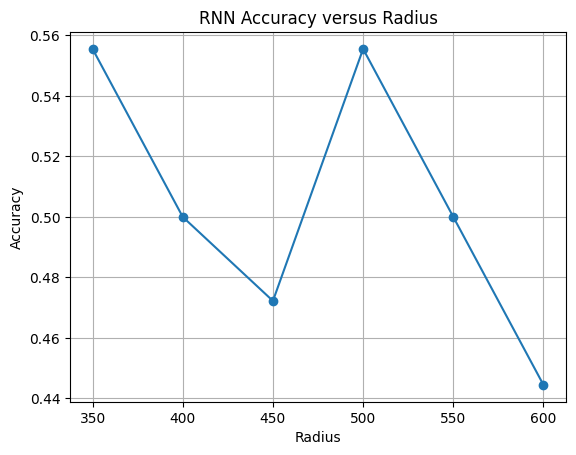

In [8]:
# plot accuracy versus radius
plt.plot(rnn_df['radius'], rnn_df['accuracy'], marker='o')
plt.title('RNN Accuracy versus Radius')
plt.xlabel('Radius')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

**Observations on RNN Performance**

1. The highest accuracy (~0.556) occurs at **radius = 350** and **radius = 500**.
2. The worst performance (0.444) is at **radius = 600**, where the radius becomes so large that virtually all points fall within the neighborhood, leading to over-generalization.
3. At **400** and **550**, accuracy is moderate (0.500). At **450**, accuracy dips further (0.472), suggesting that this particular radius often yields too few useful neighbors (triggering many 1-NN fallbacks) without capturing the broader class clusters.
4. Small radii (< 350) or radii that leave isolated test points force the fallback to 1-NN, which can introduce high variance. Very large radii blur distinctions between classes, increasing bias.
5. **Radius too small** → Many “no neighbor” cases → high variance via repeated 1-NN fallbacks.  
   **Radius too large** → Most points share neighbors → high bias and loss of class separation.
6. For this wine dataset, a radius around **350 – 500** provides the best compromise. However, even at its best, RNN (\~0.556) underperforms compared to KNN (~0.778), so KNN remains preferable here unless variable-density neighborhoods or open-set scenarios justify a radius-based approach.

## Comparison and Conclusion

- **KNN vs. RNN**: KNN achieves higher peak accuracy (\~0.778 at k=1 and k=21) than RNN’s best (~0.556 at radius=350/500).  
- **Bias–Variance Trade-off**:  
  - KNN: low k → high variance; high k → high bias.  
  - RNN: small radius → many 1-NN fallbacks (variance); large radius → class overlap (bias).  
- **When to choose**:  
  - **KNN** for datasets with clear local clusters and limited noise.  
  - **RNN** when neighborhood density varies or open-set classification is needed.  
- **Optimal parameters**:  
  - KNN: k ≈ 1 – 5 for max accuracy.  
  - RNN: radius ≈ 350 – 500 for best compromise.  

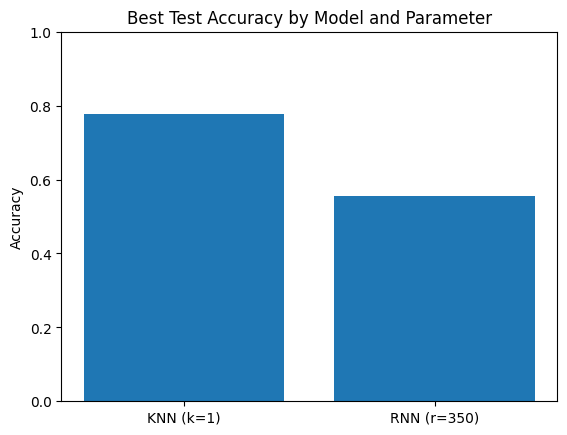

In [9]:
# Bar chart showing best accuracy and the parameter value for each model
# find best k and its accuracy
best_k = knn_df.loc[knn_df['accuracy'].idxmax(), 'k']
best_knn_acc = knn_df['accuracy'].max()

# find best radius and its accuracy
best_radius = rnn_df.loc[rnn_df['accuracy'].idxmax(), 'radius']
best_rnn_acc = rnn_df['accuracy'].max()

# label x-axis with parameter values
models = [f"KNN (k={best_k})", f"RNN (r={best_radius})"]
scores = [best_knn_acc, best_rnn_acc]

plt.bar(models, scores)
plt.title("Best Test Accuracy by Model and Parameter")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
